In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('../..')
from hamp_pred.src.input_prep.prepare_sequence import MultiChainOperator, SeqWindow
from hamp_pred.src.input_prep.encode import MultiEncoder, OneHotEncoderSeq, RadianEncoder #, MixedEncoder, 
from hamp_pred.src.input_prep.encode import RadiousPhobosEncoder
from hamp_pred.src.predictor_config import PredictionConfig #,SEQ_ENCODING_EXTERNAL DEFAULT_CONF, 
from hamp_pred.src.models.common.models import BaseConvolutionalWrapper #, BaseLinearWrapper
from hamp_pred.src.predictor import Predictor

2023-04-23 14:42:08.309098: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 14:42:08.450199: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-04-23 14:42:09.021709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-23 14:42:09.021794: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

## Prepare data

In [2]:
DATA_DIR = '../../data/input'

# data set contains train and validation sets
# the val set is used for eraly stopping 
data = f'{DATA_DIR}/af2_clean_model_1.p'
data = pd.read_pickle(data)
data['n_seq'] = data['n_seq'].apply(lambda x: x[1:-1])
data['c_seq'] = data['c_seq'].apply(lambda x: x[1:-1])
data['train_seq'] = data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
assert all(data['train_seq'].str.len() == 22)

# separate test set used to pick the best model
#data_test = f'{DATA_DIR}/af_clean_model_test.p'
#data_test = pd.read_pickle(data_test)


In [3]:
data['class'].value_counts()

train    3978
val       994
Name: class, dtype: int64

## Train and validate

In [4]:
def get_rmse(val, mod):
    seqs = list(val.train_seq)
    tr=[]
    for n,r in val.iterrows():
        tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
    res = mod.predict(seqs)
    pr = []
    for n,r in res.iterrows():
        pr.append(np.mean(r['N_pred'])/2)
        
    return np.mean((np.array(tr)-np.array(pr)) **2 ) ** 0.5

In [5]:
def train(data, conf, version):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_rot', config=conf, version=version)
    trained = mod.train(data)
    return mod, trained

def get_mod(conf=None, version=None):
    operator = MultiChainOperator(MultiEncoder([RadiousPhobosEncoder(), OneHotEncoderSeq()]), SeqWindow(11, 11), RadianEncoder(100),  SeqWindow(11, 11, null_char=[[0]]),
                                          parallel=True)
    conf = PredictionConfig(BaseConvolutionalWrapper, operator, conf)
    mod = Predictor('hamp_rot', config=conf, version=version)
    return mod
    

In [6]:
def opt_conf(data, tune=False):
    
    # data: train and val (val for the eraly stopping)
    
    data_val = data[data['class'] == 'val']
    
    results = {}

    # parameters grid
    kernels = [(3, 5, 7)]
    layers = [5, 7]
    lstm = [1, 2]
    dense = [1, 3]
    
    for kern in kernels:
        for l in layers:
            for ls in lstm:
                for d in dense:
                    model_config = {
                        'activation': 'tanh',
                        'norm': True,
                        'n_layers': l,
                        'kernel_sizes': kern,
                        'lstm': ls,
                        'dense': d,
                        'reshape_out': False,
                        'epochs': 100
                    }
                    version = '_'.join([str(x) for x in ["_".join([str(i) for i in kern]), l, ls, d]])
                    if tune:
                        mod, trained = train(data, model_config, version)
                    else:
                        mod = get_mod(model_config, version)
                        
                    results[version] = (get_rmse(data_val, mod), model_config)
    return results
        

## Tune hiperparameters

In [7]:
opt_res = opt_conf(data, tune=True)  

2023-04-23 14:42:12.316155: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 14:42:12.889427: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 7380 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1


Epoch 1/100


2023-04-23 14:42:18.346106: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8204
2023-04-23 14:42:18.595787: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-23 14:42:18.596325: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-23 14:42:18.596352: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-04-23 14:42:18.596897: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-04-23 14:42:18.597496: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.


63/63 [==============================] - 8s 130ms/sample - loss: 0.0341 - mae: 0.1056 - val_loss: 0.0244 - val_mae: 0.0992 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 2s 28ms/sample - loss: 0.0148 - mae: 0.0761 - val_loss: 0.0173 - val_mae: 0.0812 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 2s 26ms/sample - loss: 0.0115 - mae: 0.0694 - val_loss: 0.0161 - val_mae: 0.0754 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 2s 24ms/sample - loss: 0.0085 - mae: 0.0601 - val_loss: 0.0168 - val_mae: 0.0823 - lr: 0.0010
Epoch 5/100
63/63 [==============================] - 2s 28ms/sample - loss: 0.0063 - mae: 0.0519 - val_loss: 0.0155 - val_mae: 0.0767 - lr: 0.0010
Epoch 6/100
63/63 [==============================] - 1s 24ms/sample - loss: 0.0052 - mae: 0.0482 - val_loss: 0.0175 - val_mae: 0.0812 - lr: 0.0010
Epoch 7/100
63/63 [==============================] - 2s 24ms/sample - loss: 0.0044 - mae: 0.0446 - val_loss: 0.0156 - val_mae: 0.

63/63 [==============================] - 2s 24ms/sample - loss: 3.4774e-04 - mae: 0.0133 - val_loss: 0.0139 - val_mae: 0.0672 - lr: 1.0000e-06
Epoch 53/100
63/63 [==============================] - 1s 24ms/sample - loss: 3.5318e-04 - mae: 0.0134 - val_loss: 0.0139 - val_mae: 0.0672 - lr: 1.0000e-06
Epoch 54/100
63/63 [==============================] - 2s 24ms/sample - loss: 3.4859e-04 - mae: 0.0133 - val_loss: 0.0139 - val_mae: 0.0672 - lr: 1.0000e-06
Epoch 55/100
63/63 [==============================] - 1s 24ms/sample - loss: 3.3835e-04 - mae: 0.0131 - val_loss: 0.0139 - val_mae: 0.0672 - lr: 1.0000e-06
Epoch 56/100
63/63 [==============================] - 2s 24ms/sample - loss: 3.5916e-04 - mae: 0.0135 - val_loss: 0.0139 - val_mae: 0.0672 - lr: 1.0000e-06
Epoch 57/100
63/63 [==============================] - 1s 24ms/sample - loss: 3.4633e-04 - mae: 0.0133 - val_loss: 0.0139 - val_mae: 0.0672 - lr: 1.0000e-06
Epoch 58/100
 0/63 [..............................] - ETA: 0s - loss: 3.3628e

Epoch 1/100
63/63 [==============================] - 10s 154ms/sample - loss: 0.0342 - mae: 0.1069 - val_loss: 0.0249 - val_mae: 0.1013 - lr: 0.0010
Epoch 2/100
63/63 [==============================] - 2s 31ms/sample - loss: 0.0155 - mae: 0.0776 - val_loss: 0.0157 - val_mae: 0.0758 - lr: 0.0010
Epoch 3/100
63/63 [==============================] - 2s 27ms/sample - loss: 0.0102 - mae: 0.0639 - val_loss: 0.0163 - val_mae: 0.0779 - lr: 0.0010
Epoch 4/100
63/63 [==============================] - 2s 27ms/sample - loss: 0.0080 - mae: 0.0573 - val_loss: 0.0162 - val_mae: 0.0799 - lr: 0.0010
Epoch 5/100
63/63 [==============================] - 2s 27ms/sample - loss: 0.0075 - mae: 0.0575 - val_loss: 0.0165 - val_mae: 0.0783 - lr: 0.0010
Epoch 6/100
63/63 [==============================] - 2s 26ms/sample - loss: 0.0066 - mae: 0.0535 - val_loss: 0.0167 - val_mae: 0.0823 - lr: 0.0010
Epoch 7/100
63/63 [==============================] - 2s 26ms/sample - loss: 0.0050 - mae: 0.0470 - val_loss: 0.0157 

63/63 [==============================] - 2s 29ms/sample - loss: 6.5601e-04 - mae: 0.0177 - val_loss: 0.0144 - val_mae: 0.0693 - lr: 1.0000e-04
Epoch 26/100
63/63 [==============================] - 2s 29ms/sample - loss: 5.9300e-04 - mae: 0.0170 - val_loss: 0.0143 - val_mae: 0.0691 - lr: 1.0000e-04
Epoch 27/100
63/63 [==============================] - 2s 29ms/sample - loss: 5.8243e-04 - mae: 0.0167 - val_loss: 0.0144 - val_mae: 0.0692 - lr: 1.0000e-04
Epoch 28/100
63/63 [==============================] - 2s 29ms/sample - loss: 6.0143e-04 - mae: 0.0170 - val_loss: 0.0144 - val_mae: 0.0693 - lr: 1.0000e-04
Epoch 29/100
63/63 [==============================] - 2s 32ms/sample - loss: 6.6318e-04 - mae: 0.0179 - val_loss: 0.0142 - val_mae: 0.0692 - lr: 1.0000e-04
Epoch 30/100
 0/63 [..............................] - ETA: 0s - loss: 5.1042e-04 - mae: 0.0157
Epoch 30: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
63/63 [==============================] - 2s 32ms/sample - lo

Epoch 29/100
63/63 [==============================] - 2s 29ms/sample - loss: 5.2582e-04 - mae: 0.0159 - val_loss: 0.0137 - val_mae: 0.0674 - lr: 1.0000e-04
Epoch 30/100
63/63 [==============================] - 2s 33ms/sample - loss: 4.7203e-04 - mae: 0.0152 - val_loss: 0.0136 - val_mae: 0.0680 - lr: 1.0000e-04
Epoch 31/100
 0/63 [..............................] - ETA: 0s - loss: 4.8177e-04 - mae: 0.0153
Epoch 31: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
63/63 [==============================] - 2s 32ms/sample - loss: 4.8177e-04 - mae: 0.0153 - val_loss: 0.0136 - val_mae: 0.0677 - lr: 1.0000e-04
Epoch 32/100
63/63 [==============================] - 2s 29ms/sample - loss: 4.2735e-04 - mae: 0.0145 - val_loss: 0.0136 - val_mae: 0.0673 - lr: 1.0000e-05
Epoch 33/100
63/63 [==============================] - 2s 29ms/sample - loss: 4.2263e-04 - mae: 0.0144 - val_loss: 0.0136 - val_mae: 0.0674 - lr: 1.0000e-05
Epoch 34/100
63/63 [==============================] - 2s 29m

63/63 [==============================] - 2s 34ms/sample - loss: 6.3000e-04 - mae: 0.0171 - val_loss: 0.0140 - val_mae: 0.0678 - lr: 1.0000e-04
Epoch 28/100
63/63 [==============================] - 2s 35ms/sample - loss: 5.5467e-04 - mae: 0.0160 - val_loss: 0.0140 - val_mae: 0.0677 - lr: 1.0000e-04
Epoch 29/100
63/63 [==============================] - 2s 30ms/sample - loss: 5.0908e-04 - mae: 0.0154 - val_loss: 0.0140 - val_mae: 0.0676 - lr: 1.0000e-04
Epoch 30/100
63/63 [==============================] - 2s 30ms/sample - loss: 4.6535e-04 - mae: 0.0148 - val_loss: 0.0140 - val_mae: 0.0682 - lr: 1.0000e-04
Epoch 31/100
63/63 [==============================] - 2s 34ms/sample - loss: 4.7775e-04 - mae: 0.0150 - val_loss: 0.0140 - val_mae: 0.0680 - lr: 1.0000e-04
Epoch 32/100
63/63 [==============================] - 2s 30ms/sample - loss: 4.4036e-04 - mae: 0.0145 - val_loss: 0.0141 - val_mae: 0.0676 - lr: 1.0000e-04
Epoch 33/100
63/63 [==============================] - 2s 30ms/sample - loss: 

63/63 [==============================] - 2s 33ms/sample - loss: 0.0012 - mae: 0.0234 - val_loss: 0.0141 - val_mae: 0.0713 - lr: 0.0010
Epoch 28/100
 0/63 [..............................] - ETA: 0s - loss: 0.0013 - mae: 0.0241
Epoch 28: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
63/63 [==============================] - 2s 34ms/sample - loss: 0.0013 - mae: 0.0241 - val_loss: 0.0142 - val_mae: 0.0687 - lr: 0.0010
Epoch 29/100
63/63 [==============================] - 2s 38ms/sample - loss: 8.0232e-04 - mae: 0.0188 - val_loss: 0.0137 - val_mae: 0.0678 - lr: 1.0000e-04
Epoch 30/100
63/63 [==============================] - 2s 38ms/sample - loss: 6.1284e-04 - mae: 0.0167 - val_loss: 0.0136 - val_mae: 0.0672 - lr: 1.0000e-04
Epoch 31/100
63/63 [==============================] - 2s 33ms/sample - loss: 5.0744e-04 - mae: 0.0153 - val_loss: 0.0136 - val_mae: 0.0672 - lr: 1.0000e-04
Epoch 32/100
63/63 [==============================] - 2s 34ms/sample - loss: 5.1693e-04 - mae

Epoch 23/100
63/63 [==============================] - 2s 34ms/sample - loss: 0.0022 - mae: 0.0316 - val_loss: 0.0150 - val_mae: 0.0740 - lr: 0.0010
Epoch 24/100
63/63 [==============================] - 2s 34ms/sample - loss: 0.0016 - mae: 0.0267 - val_loss: 0.0146 - val_mae: 0.0694 - lr: 0.0010
Epoch 25/100
63/63 [==============================] - 2s 38ms/sample - loss: 0.0014 - mae: 0.0246 - val_loss: 0.0141 - val_mae: 0.0701 - lr: 0.0010
Epoch 26/100
 0/63 [..............................] - ETA: 0s - loss: 0.0015 - mae: 0.0259
Epoch 26: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
63/63 [==============================] - 2s 34ms/sample - loss: 0.0015 - mae: 0.0259 - val_loss: 0.0154 - val_mae: 0.0728 - lr: 0.0010
Epoch 27/100
63/63 [==============================] - 2s 39ms/sample - loss: 0.0011 - mae: 0.0219 - val_loss: 0.0135 - val_mae: 0.0672 - lr: 1.0000e-04
Epoch 28/100
63/63 [==============================] - 2s 39ms/sample - loss: 6.9432e-04 - mae: 0.017

In [8]:
# kern, layers, lstm, dense
for pos, (k, (v, model_config)) in enumerate(sorted(opt_res.items(), key=lambda item: item[1])):
    if pos==0:
        best_model_config = model_config
        best_file = k
        
    print(pos+1, k, round(v, 2))

1 3_5_7_7_2_3 4.23
2 3_5_7_7_2_1 4.26
3 3_5_7_7_1_1 4.26
4 3_5_7_5_1_1 4.28
5 3_5_7_5_1_3 4.31
6 3_5_7_7_1_3 4.32
7 3_5_7_5_2_1 4.32
8 3_5_7_5_2_3 4.36


## Best Config

In [9]:
best_model_config

{'activation': 'tanh',
 'norm': True,
 'n_layers': 7,
 'kernel_sizes': (3, 5, 7),
 'lstm': 2,
 'dense': 3,
 'reshape_out': False,
 'epochs': 100,
 'task': 'hamp_rot',
 'version': '3_5_7_7_2_3',
 'data_dir': '/home/users/sdunin/calc/HAMPpred/data/output/weights/hamp_rot/3_5_7_7_2_3'}

In [10]:
mod = get_mod(conf=best_model_config, version=best_file)

# PDB set performance

In [11]:
test_data = pd.read_pickle(f'{DATA_DIR}/pdb_measure.p')

In [12]:
test_data = pd.read_pickle(os.path.join(DATA_DIR, 'pdb_measure.p'))
test_data = test_data[~test_data.mutant]
test_data.rename(columns={'seq1':'n_seq', 'seq2':'c_seq', 'n_list':'n_crick_mut', 'c_list':'c_crick_mut'}, inplace=True)
test_data['n_seq'] = test_data['n_seq'].apply(lambda x: x[1:-1])
test_data['c_seq'] = test_data['c_seq'].apply(lambda x: x[1:-1])
test_data['train_seq'] = test_data.apply(lambda x: x['n_seq'] + x['c_seq'], axis=1)
len(test_data)

11

In [13]:
seq = []
tr = []
for n,r in test_data.iterrows():
    seq.append(r['n_seq'] + r['c_seq'])
    tr.append(np.mean((r['rot'][0::2] + r['rot'][1::2]) / 2)/2)
res = mod.predict(seq)
pr = []
for n,r in res.iterrows():
    pr.append(np.mean(r['N_pred'])/2)

1/1 [==============================] - 2s 2s/step


Text(0.5, 1.0, 'HAMPpred predictions')

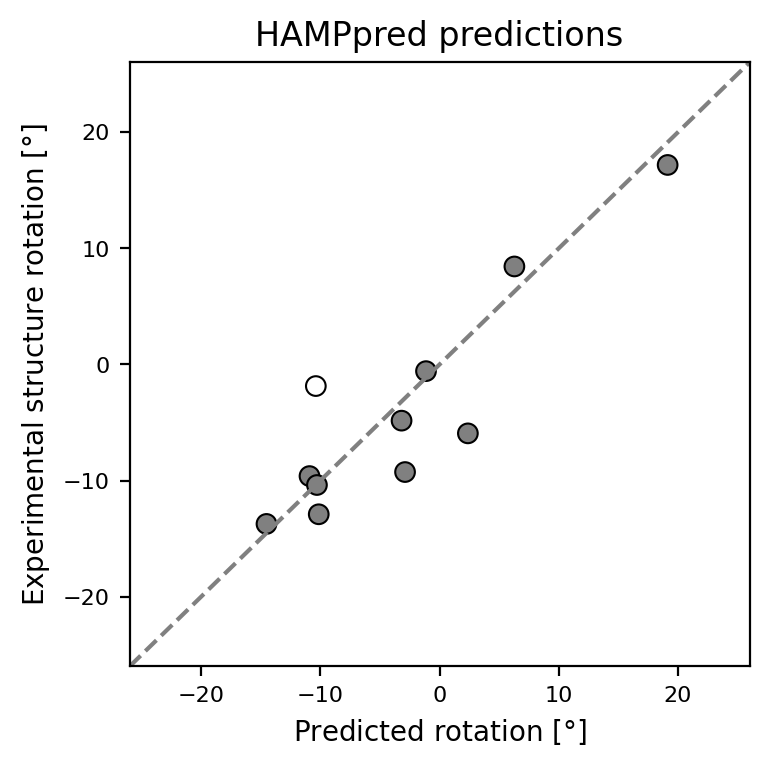

In [14]:
title_font_size = 12
label_font_size = 10
tick_font_size = 8

fig, ax = plt.subplots(1,1, figsize=(4, 4), dpi=200)

colors = ['white' if i=='1_2l7i.pdb' else 'grey' for i in test_data.index]

ax.scatter(pr, tr, color=colors, lw=0.75, edgecolors='k', s=50)

ax.set_ylim(-26, 26)
ax.set_xlim(-26, 26)
ax.plot([0, 1], [0, 1], '--', transform=ax.transAxes, color='grey')

ax.set_xlabel(r'Predicted rotation [$\degree$]', size=label_font_size)
ax.set_ylabel(r'Experimental structure rotation [$\degree$]', size=label_font_size)

ax.tick_params(axis='both', which='major', labelsize=tick_font_size)
ax.tick_params(axis='both', which='minor', labelsize=tick_font_size)
ax.set_title("HAMPpred predictions", size=title_font_size)

In [15]:
np.mean((np.asarray(tr)-np.asarray(pr)) **2 ) ** 0.5

4.302525585382851